<a href="https://colab.research.google.com/github/kmouts/PPS_MultiComms/blob/master/sound_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ανάλυση Ήχου

Στο εργαστήριο αυτό θα ασχοληθούμε την Ανάλυση Ήχου, χρησιμοποιώντας μια νέα βιβλιοθήκη Python: **pyAudioAnalysis** [https://github.com/tyiannak/pyAudioAnalysis]. 

In [0]:
!git clone https://github.com/tyiannak/pyAudioAnalysis.git
!pip install -q -r pyAudioAnalysis/requirements.txt
!pip install -q -e pyAudioAnalysis/.

fatal: destination path 'pyAudioAnalysis' already exists and is not an empty directory.


## Εξαγωγή χαρακτηριστικών

Υπάρχουν δύο στάδια στην μεθοδολογία εξαγωγής ηχητικών χαρακτηριστικών:


*   Εξαγωγή χαρακτηριστικών Μικρής Διάρκειας (Short-term): Γίνεται με τη χρήση της συνάρτησης `feature_extraction()` από το αρχείο `ShortTermFeatures.py`. Χωρίζει το εισαγόμενο σήμα σε μικρά χρονικά παράθυρα (frames) και υπολογίζει κάποια χαρακτηριστικά για το κάθε παράθυρο. Αυτή η διαδικασία οδηγεί σε μια σειρά από λίστες χαρακτηριστικών για όλο το σήμα
*   Εξαγωγή χαρακτηριστικών Μέσης Διάρκειας (Mid-term): Σε πολλές περιπτώσεις το σήμα αντιπροσωπεύεται από στατιστικές των χαρακτηριστικών μικρής διάρκειας. Η συνάρτηση `mid_feature_extraction()` από το αρχείο `MidTermFeatures.py` εξάγει στατιστικές (πχ μέση τιμή και τυπική απόκλιση) σε κάθε σειρά χαρακτηριστικών μικρής διάρκειας.


Το pyAudioAnalysis υποστηρίζει την εξαγωγή 34 χαρακτηριστικών (features) από αρχεία ήχου. Ας δούμε 2 από αυτά: **Zero Crossing Rate - ZCR** (The rate of sign-changes of the signal during the duration of a particular frame) και **Energy** (The sum of squares of the signal values, normalized by the respective frame length).

In [0]:
!apt-get install -qq ffmpeg
!apt-get install -qq python3-magic
!pip install -q python-magic

In [0]:
import sys
sys.path.append('/content/pyAudioAnalysis')

In [0]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt


Για να διαβαστούν τα ηχητικά δείγματα καλούμε τη συνάρτηση `read_audio_file()` από το αρχείο `audioBasicIO.py`.



In [0]:
[Fs, x] = audioBasicIO.read_audio_file("pyAudioAnalysis/pyAudioAnalysis/data/doremi.wav")

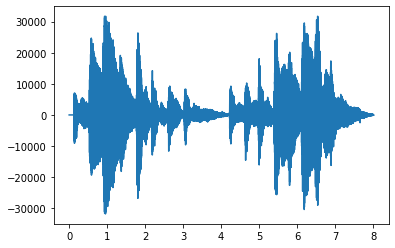

In [0]:
# Διάγραμμα με την κυματομορφή
import numpy
timeX = numpy.arange(0, x.shape[0] / float(Fs), 1.0 / Fs)
plt.plot(timeX, x)
plt.show()

Ο  επόμενος κώδικας χρησιμοποιεί τη συνάρτηση `feature_extraction()` από το αρχείο `ShortTermFeatures.py` για την εξαγωγή χαρακτηριστικών μικρής διάρκειας ενός ηχητικού σήματος. Θέτουμε χρονικό παράθυρο (frame) 50 msecs και βήμα 25 msecs (με 50% επικάλυψη).

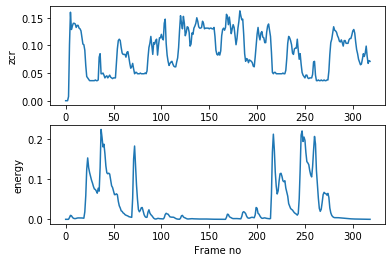

In [0]:
F, f_names = ShortTermFeatures.feature_extraction(x, Fs, 0.050*Fs, 0.025*Fs)
plt.subplot(2,1,1); plt.plot(F[0,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[0]) 
plt.subplot(2,1,2); plt.plot(F[1,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[1]); plt.show()

O παραπάνω κώδικας επίσης κάνει το διάγραμμα σειράς των δύο πρώτων χαρακτηριστικών: `zero crossing rate` και `signal energy`. Η συνάρτηση `feature_extraction()` επιστρέφει έναν πίνακα numpy  με 34 γραμμές και  N στήλες, όπου N το πλήθος των short-term frames που χωράνε στην εγγραφή του ήχου.

## Οπτική Ανάλυση του Ήχου

### Φασματικό Διάγραμμα

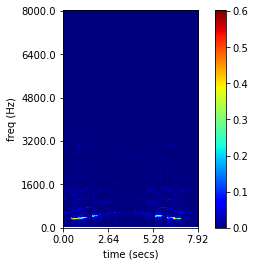

In [0]:
[fs, x] = audioBasicIO.read_audio_file("pyAudioAnalysis/pyAudioAnalysis/data/doremi.wav")
x = audioBasicIO.stereo_to_mono(x)
specgram, TimeAxis, FreqAxis = ShortTermFeatures.spectrogram(x, fs, round(fs * 0.040),round(fs * 0.040), True)

### Χρωματικό Διάγραμμα

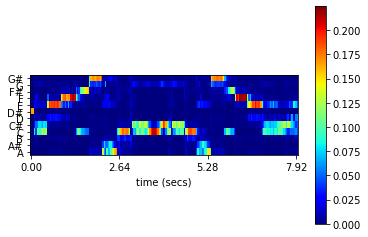

In [0]:
specgram, TimeAxis, FreqAxis = ShortTermFeatures.chromagram(x, fs, round(fs * 0.040),
                                                 round(fs * 0.040), True)

## Εκπαίδευση ενός Ταξινομητή Ήχου


Στην συνέχεια θα εκπαιδεύσουμε έναν ταξινομητή που χρησιμοποιεί Cross-Validation για να διαλέξει την βέλτιστη παράμετρο για τον ταξινομητή (πχ τη παράμετρο soft margin C για SVM, το πλήθος των δέντρων για Random Forests, ο αριθμός των γειτόνων k για Knn κλπ.) Το παραγόμενο μοντέλο σώζεται στη θέση που ορίζουμε με την παράμετρο –o.

Πρώτα όμως ας φορτώσουμε τα αρχεία εκπαίδευσης, και τα αρχεία για το τελικό τέστ.

In [0]:
import requests, zipfile, io

r = requests.get( 'https://github.com/kmouts/PPS_MultiComms/blob/master/AudioAnaysisData.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [0]:
ls sampleData/

'Cat --- cat_11.wav'   'Cat --- cat_15.wav'      'Dog --- barking_14.wav'
'Cat --- cat_12.wav'   'Dog --- barking_11.wav'  'Dog --- barking_15.wav'
'Cat ---  cat_13.wav'  'Dog --- barking_12.wav'
'Cat --- cat_14.wav'   'Dog --- barking_13.wav'


In [0]:
ls trainingData/

cat/  dog/


In [0]:
!mkdir models

In [0]:
!python pyAudioAnalysis/pyAudioAnalysis/audioAnalysis.py trainClassifier -i trainingData/cat/ trainingData/dog/ --method svm -o models/svmSM

Analyzing file 1 of 10: trainingData/cat/cat_1.wav
Analyzing file 2 of 10: trainingData/cat/cat_10.wav
Analyzing file 3 of 10: trainingData/cat/cat_2.wav
Analyzing file 4 of 10: trainingData/cat/cat_3.wav
Analyzing file 5 of 10: trainingData/cat/cat_4.wav
Analyzing file 6 of 10: trainingData/cat/cat_5.wav
Analyzing file 7 of 10: trainingData/cat/cat_6.wav
Analyzing file 8 of 10: trainingData/cat/cat_7.wav
Analyzing file 9 of 10: trainingData/cat/cat_8.wav
Analyzing file 10 of 10: trainingData/cat/cat_9.wav
Feature extraction complexity ratio: 14.2 x realtime
Analyzing file 1 of 10: trainingData/dog/dog_barking_1.wav
Analyzing file 2 of 10: trainingData/dog/dog_barking_10.wav
Analyzing file 3 of 10: trainingData/dog/dog_barking_2.wav
Analyzing file 4 of 10: trainingData/dog/dog_barking_3.wav
Analyzing file 5 of 10: trainingData/dog/dog_barking_4.wav
Analyzing file 6 of 10: trainingData/dog/dog_barking_5.wav
Analyzing file 7 of 10: trainingData/dog/dog_barking_6.wav
Analyzing file 8 of 1

In [0]:
%ls -la models/

total 68
drwxr-xr-x 2 root root  4096 May  3 06:29 ./
drwxr-xr-x 1 root root  4096 May  3 06:29 ../
-rw-r--r-- 1 root root 23514 May  3 06:29 svmSM
-rw-r--r-- 1 root root 29232 May  3 06:29 svmSM.arff
-rw-r--r-- 1 root root  2591 May  3 06:29 svmSMMEANS


### Ταξινόμηση ‘άγνωστων’ ήχων

Ας δούμε τώρα πόσο καλά τα πάει ο ταξινομητής μας:

In [0]:
!python pyAudioAnalysis/pyAudioAnalysis/audioAnalysis.py classifyFolder -i sampleData/ --model svm --classifier models/svmSM --details



sampleData/Cat ---  cat_13.wav	cat
sampleData/Cat --- cat_11.wav	cat
sampleData/Cat --- cat_12.wav	cat
sampleData/Cat --- cat_14.wav	dog
sampleData/Cat --- cat_15.wav	cat
sampleData/Dog --- barking_11.wav	cat
sampleData/Dog --- barking_12.wav	dog
sampleData/Dog --- barking_13.wav	dog
sampleData/Dog --- barking_14.wav	dog
sampleData/Dog --- barking_15.wav	dog
cat                 		5
dog                 		5


## Αφαίρεση σιγής

Η συνάρτηση `silence_removal()` από το αρχείο `audioSegmentation.py` παίρνει σαν είσοδο ένα αρχείο ηχογράφησης και εξάγει τμήματα που αντιστοιχούν σε ηχητικά γεγονότα. Με αυτό το τρόπο, τμήματα "σιγής" αφαιρούνται από το σήμα.

Αυτό επιτυγχάνεται με μια ημι-εποπτευόμενη (semi-supervised) προσέγγιση: Πρώτα εκπαιδεύεται ένα SVM μοντέλο στο να διακρίνει frames υψηλής/χαμηλής ενέργειας. Για το σκοπό αυτό γίνεται χρήση των 10% των υψηλότερων και 10% των χαμηλότερων ενεργειακά πλαισίων. Το παραγόμενο μοντέλο τρέχει σε όλο το αρχείο (με έξοδο την πιθανότητα) και με δυναμική κατωφλίωση (επιλογή –weight) για  να διακρίνει τα ενεργά τμήματα.

Η συνάρτηση `silence_removal()` έχει τα ακόλουθα ορίσματα: το σήμα, συχνότητα δειγματοληψίας, μήκος και βήμα παραθύρου, το παράθυρο (σε δευτερόλεπτα) που θα χρησιμοποιηθεί για την ομαλοποίηση της SVM σειράς πιθανοτήτων, ένας αριθμός μεταξύ 0 και 1 που ορίζει πόσο "αυστηρή" είναι η κατωφλίωση και τέλος μια boolean μεταβλητή σχετική με τη σχεδίαση του αποτελέσματος. Ας δούμε ένα παράδειγμα:

In [0]:
from pathlib import Path
inputFile = Path("trainingData/cat/cat_1.wav")
smoothingWindow = 0.9
weight = 0.6
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


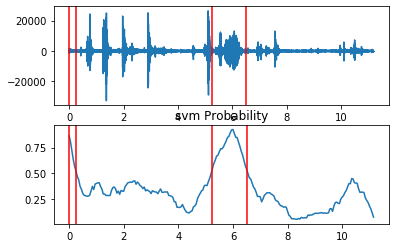

In [0]:
    from pyAudioAnalysis import audioSegmentation as aS
    import scipy.io.wavfile as wavfile

    [fs, x] = audioBasicIO.read_audio_file(inputFile)
    segmentLimits = aS.silence_removal(x, fs, 0.05, 0.05,
                                       smoothingWindow, weight, True)
    for i, s in enumerate(segmentLimits):
        strOut = "tmp/{0:s}_{1:.3f}-{2:.3f}.wav".format(inputFile.name[0:-4], s[0], s[1])
        wavfile.write(strOut, fs, x[int(fs * s[0]):int(fs * s[1])])

In [0]:
!ls count2.wav/tmp

ls: cannot access 'count2.wav/tmp': No such file or directory


Ανάλογα με το είδος της ηχογράφησης, θα πρέπει να χρησιμοποιηθούν διαφορετικές τιμές στο μήκος παραθύρου ομαλοποίησης και στο βάρος πιθανότητας. Πχ (1.0, 0.3) για ήχους που έχουν ανάμεσα μεγάλα διαστήματα σιγής. Για μια ηχογράφηση συνεχής ομιλίας (πχ count2.wav), θα πρέπει να χρησιμοποιηθεί μικρότερο παράθυρο και αυστηρότερο κατώφλι, πχ (0.1, 0.6)

## Αναγνώριση ομιλητή (Speaker Diarization)

Η Αναγνώριση Ομιλητή αυτόματα απαντά στην ερώτηση "ποιός μίλησε πότε".
Γενικά τα βήματα που ακολουθεί εδώ ο αλγόριθμος είναι:


*   Εξαγωγή Χαρακτηριστικών (μικρής και μέσης διάρκειας). Για κάθε μέσης διάρκειας κομμάτι υπολογίζονται στατιστικές, καθώς και τη πιθανότητα να πρόκειται για ανδρική ή γυναικεία φωνή. (Εδώ χρησιμοποιείται και ένα εκπαιδευμένο μοντέλο, το `knnSpeakerFemaleMale`)
*   (προαιρετικά) Βήμα FLsD: προβολές των χαρακτηριστικών μέσης διάρκειας με τη προσέγγιση FLsD.
*   Ομαδοποίηση: Χρήση μεθόδου k-means (είτε στον αρχικό χώρο των χαρακτηριστικών είτε στον υποχώρο του FLsD). Αν το πλήθος των ομιλητών δεν είναι γνωστό από την αρχή, τότε επαναλαμβάνεται η διαδικασία για μια σειρά αριθμών, και με το κριτήριο Silhouette εκτιμάται το πλήθος των ομιλητών.
*   Ομαλοποίηση: Σε αυτό το βήμα συνδιάζονται α) ένα median φίλτρο στις εξαχθείσες ομάδες και b) ομαλοποίηση με Viterbi.

Η συνάρτηση `speakerDiarization()` από το αρχείο `audioSegmentation.py` εξάγει μια σειρά από ηχητικά κομμάτια με τις αντίστοιχες εττικέτες τους. (Για λεπτομέρειες στα ορίσματα κοιτάξτε τον κώδικα). Επιπλέον, η συνάρτηση `evaluateSpeakerDiarization()` χρησιμοποιείται από την  `speakerDiarization()` για να συγκρίνει τα αποτελέσματα με την αλήθεια (ground-truth) και να εξάγει μετρικές για την ακρίβεια. .Συγκεκριμένα, υπολογίζονται οι μετρικές cluster purity και  speaker purity. Για να είναι δυνατή η παραγωγή αυτών των μετρικών, χρειάζεται η ύπαρξη του αρχείου αληθείας `.segment` με το ίδιο όνομα με το WAV αρχείο.

In [0]:
ls -la pyAudioAnalysis/pyAudioAnalysis/data/diarizationExample.wav

-rwxr-xr-x 1 root root 1343534 May  3 05:46 pyAudioAnalysis/pyAudioAnalysis/data/diarizationExample.wav*


88.1	88.1


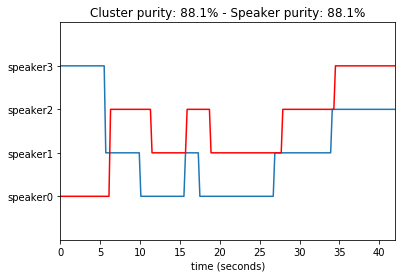

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2.])

In [0]:
inputFile = "pyAudioAnalysis/pyAudioAnalysis/data/diarizationExample.wav"
numSpeakers = 4
aS.speaker_diarization(inputFile, numSpeakers, lda_dim=0, plot_res=True)

Η συνάρτηση παίρνει ως ορίσματα: -i <fileName>, --num <numberOfSpeakers (0 for unknown)>, --flsd (flag to enable FLsD method). Στο γράφημα που βλέπουμε παραπάνω, με κόκκινο είναι το ground-truth. Στο τίτλο του γραφήματος αναγράφονται και η ακρίβεια του αλγόριθμου.

## Απεικόνιση ομοιότητας ήχων

Η επόμενη λειτουργία εξάγει τα χαρακτηριστικά μεγάλης διάρκειας από αρχεία ήχων, εφαρμόζει τεχνική μείωσης διαστάσεων (dimensionality reduction) με PCA ή LDA (που είναι μια εποπτευόμενη [supervised] μέθοδος). Οι κλάσεις -στη δεύτερη περίπτωση= λαμβάνονται από το όνομα των αρχείων. Κοιτάξτε τα ονόματα στον κατάλογο sampleData:

In [131]:
!ls sampleData

'Cat --- cat_11.wav'   'Cat --- cat_15.wav'	 'Dog --- barking_14.wav'
'Cat --- cat_12.wav'   'Dog --- barking_11.wav'  'Dog --- barking_15.wav'
'Cat ---  cat_13.wav'  'Dog --- barking_12.wav'
'Cat --- cat_14.wav'   'Dog --- barking_13.wav'


Από τις μειωμένες διαστάσεις που προκύπτουν από την PCA/LDA, υπολογίζεται ένας πίνακας ομοιότητας και με κατωφλίωση προκύπτει ο γράφος ομοιότητας, που αναπαρίσταται σε ένα  διάγραμμα χορδών (chordial). 
Εδώ βλέπουμε το γράφο ομοιότητας σε δύο άξονες:

Analyzing file 1 of 10: sampleData/Cat ---  cat_13.wav
Analyzing file 2 of 10: sampleData/Cat --- cat_11.wav
Analyzing file 3 of 10: sampleData/Cat --- cat_12.wav
Analyzing file 4 of 10: sampleData/Cat --- cat_14.wav
Analyzing file 5 of 10: sampleData/Cat --- cat_15.wav
Analyzing file 6 of 10: sampleData/Dog --- barking_11.wav
Analyzing file 7 of 10: sampleData/Dog --- barking_12.wav
Analyzing file 8 of 10: sampleData/Dog --- barking_13.wav
Analyzing file 9 of 10: sampleData/Dog --- barking_14.wav
Analyzing file 10 of 10: sampleData/Dog --- barking_15.wav
Feature extraction complexity ratio: 14.3 x realtime


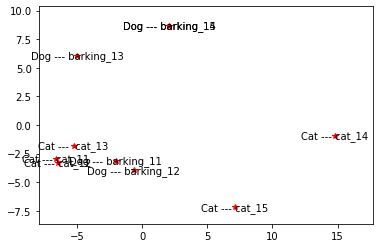

In [141]:
from pyAudioAnalysis import audioVisualization as aV
aV.visualizeFeaturesFolder("sampleData/", "pca", "")

Κοιτάξτε το περιεχόμενο των καταλόγων visualization_* που δημιουργήθηκαν:

In [142]:
# !rm -rf visualization*
!ls -la 

total 48
drwxr-xr-x 1 root root 4096 May  3 09:56 .
drwxr-xr-x 1 root root 4096 May  3 05:42 ..
drwxr-xr-x 1 root root 4096 Apr 29 16:14 .config
drwxr-xr-x 2 root root 4096 May  3 06:29 models
drwxr-xr-x 6 root root 4096 May  3 05:47 pyAudioAnalysis
drwxr-xr-x 1 root root 4096 Apr  3 16:24 sample_data
drwxr-xr-x 2 root root 4096 May  3 05:47 sampleData
drwxr-xr-x 2 root root 4096 May  3 07:25 tmp
drwxr-xr-x 4 root root 4096 May  3 05:47 trainingData
drwxr-xr-x 2 root root 4096 May  3 09:56 visualization_Chordial
drwxr-xr-x 2 root root 4096 May  3 09:56 visualizationGroup_Chordial
drwxr-xr-x 2 root root 4096 May  3 09:56 visualizationInitial_Chordial


In [0]:
# import IPython
# IPython.display.HTML(filename='visualization_Chordial/similarities.html')

In [143]:
import shutil
shutil.make_archive("/tmp/chor", 'zip', "visualizationInitial_Chordial")

'/tmp/chor.zip'

In [0]:
from google.colab import files
files.download('/tmp/chor.zip')

## Coding Task

Η ακρίβεια του ταξινομητή που φτιάξαμε προηγουμένως δεν είναι ιδιαίτερα καλή, στο περιορισμένο εύρος εκπαίδευσης που είχαμε διαθέσιμο. Μπορείτε να φτιάξετε ένα πρόγραμμα σε python, που να εκμεταλλεύεται την Αφαίρεση Σιγής και να παράγει ένα μοντέλο με καλύτερες αποδόσεις;